In [1]:
# Initialize OK
# If you see an error message, you'll need to do
# pip3 install okpy
from client.api.notebook import Notebook
ok = Notebook('proj3.ok')

ModuleNotFoundError: No module named 'client'

# Project 3: Predicting Taxi Ride Duration
## Due Date: Wednesday 3/4/20, 11:59PM

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: 

Stewart Dulaney - 904-064-791
Amy Zhao - 949-491-4465


## Score Breakdown
Question | Points
--- | ---
1b | 2
1c | 3
1d | 2
2a | 1
2b | 2
3a | 2
3b | 1
3c | 2
3d | 2
4a | 2
4b | 2
4c | 2
4d | 2
4e | 2
4f | 2
4g | 4
5b | 7
5c | 3
Total | 43

## This Assignment
In this project, you will use what you've learned in class to create a regression model that predicts the travel time of a taxi ride in New York. Some questions in this project are more substantial than those of past projects.

After this project, you should feel comfortable with the following:

- The data science lifecycle: data selection and cleaning, EDA, feature engineering, and model selection.
- Using `sklearn` to process data and fit linear regression models.
- Embedding linear regression as a component in a more complex model.

First, let's import:

In [24]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

## The Data
Attributes of all [yellow taxi](https://en.wikipedia.org/wiki/Taxicabs_of_New_York_City) trips in January 2016 are published by the [NYC Taxi and Limosine Commission](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

The full data set takes a long time to download directly, so we've placed a simple random sample of the data into `taxi.db`, a SQLite database. You can view the code used to generate this sample in the `taxi_sample.ipynb` file included with this project (not required).

Columns of the `taxi` table in `taxi.db` include:
- `pickup_datetime`: date and time when the meter was engaged
- `dropoff_datetime`: date and time when the meter was disengaged
- `pickup_lon`: the longitude where the meter was engaged
- `pickup_lat`: the latitude where the meter was engaged
- `dropoff_lon`: the longitude where the meter was disengaged
- `dropoff_lat`: the latitude where the meter was disengaged
- `passengers`: the number of passengers in the vehicle (driver entered value)
- `distance`: trip distance
- `duration`: duration of the trip in seconds

Your goal will be to predict `duration` from the pick-up time, pick-up and drop-off locations, and distance.

## Part 1: Data Selection and Cleaning

In this part, you will limit the data to trips that began and ended on Manhattan Island ([map](https://www.google.com/maps/place/Manhattan,+New+York,+NY/@40.7590402,-74.0394431,12z/data=!3m1!4b1!4m5!3m4!1s0x89c2588f046ee661:0xa0b3281fcecc08c!8m2!3d40.7830603!4d-73.9712488)). 

The below cell uses a SQL query to load the `taxi` table from `taxi.db` into a Pandas DataFrame called `all_taxi`. 

It only includes trips that have **both** pick-up and drop-off locations within the boundaries of New York City:

- Longitude is between -74.03 and -73.75 (inclusive of both boundaries)
- Latitude is between 40.6 and 40.88 (inclusive of both boundaries)

You don't have to change anything, just run this cell.

<!--
BEGIN QUESTION
name: q1a
points: 2
-->

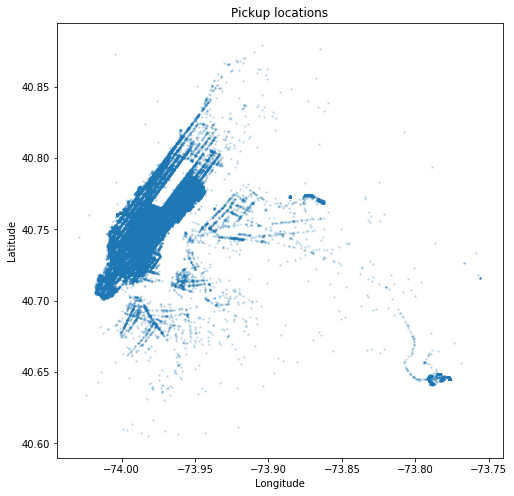

In [25]:
import sqlite3

conn = sqlite3.connect('taxi.db')
lon_bounds = [-74.03, -73.75]
lat_bounds = [40.6, 40.88]

c = conn.cursor()

my_string = 'SELECT * FROM taxi WHERE'

for word in ['pickup_lat', 'AND dropoff_lat']:
    my_string += ' {} BETWEEN {} AND {}'.format(word, lat_bounds[0], lat_bounds[1])
    
for word in ['AND pickup_lon', 'AND dropoff_lon']:
    my_string += ' {} BETWEEN {} AND {}'.format(word, lon_bounds[0], lon_bounds[1])

c.execute(my_string)

results = c.fetchall()

row_res = conn.execute('select * from taxi')
names = list(map(lambda x: x[0], row_res.description))


all_taxi = pd.DataFrame(results)
all_taxi.columns = names
all_taxi.head()

def pickup_scatter(t):
    plt.scatter(t['pickup_lon'], t['pickup_lat'], s=2, alpha=0.2)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Pickup locations')
    
plt.figure(figsize=(8, 8))
pickup_scatter(all_taxi)

A scatter plot of pickup locations shows that most of them are on the island of Manhattan. The empty white rectangle is Central Park; cars are not allowed there.

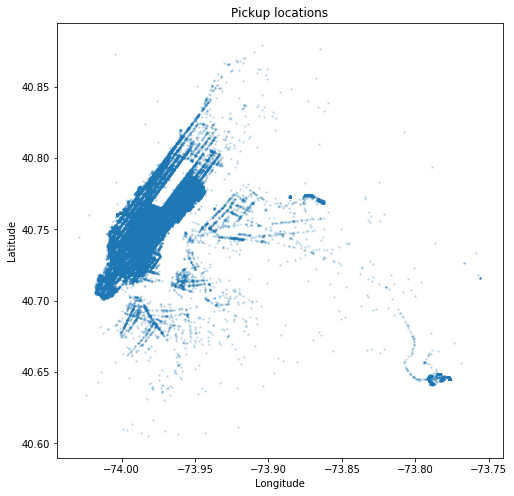

In [26]:
def pickup_scatter(t):
    plt.scatter(t['pickup_lon'], t['pickup_lat'], s=2, alpha=0.2)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Pickup locations')
    
plt.figure(figsize=(8, 8))
pickup_scatter(all_taxi)

The two small blobs outside of Manhattan with very high concentrations of taxi pick-ups are airports.

### Question 1b

Create a DataFrame called `clean_taxi` that only includes trips with a positive passenger count, a positive distance, a duration of at least 1 minute and at most 1 hour, and an average speed of at most 100 miles per hour. Inequalities should not be strict (e.g., `<=` instead of `<`) unless comparing to 0.

*The provided tests check that you have constructed `clean_taxi` correctly.*

<!--
BEGIN QUESTION
name: q1b
points: 2
-->

In [27]:
all_taxi.head(20)
clean_taxi = all_taxi[all_taxi.passengers>0]
clean_taxi = clean_taxi[clean_taxi.distance>0]

clean_taxi = clean_taxi[clean_taxi.duration>= 60]
clean_taxi = clean_taxi[clean_taxi.duration<= 3600]
clean_taxi["duration_in_hour"]= clean_taxi.duration/3600
clean_taxi = clean_taxi[(clean_taxi.distance/clean_taxi.duration_in_hour) <= 100]



clean_taxi = clean_taxi.drop(["duration_in_hour"],axis=1)



clean_taxi.head(200)

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299
3,2016-01-01 04:13:41,2016-01-01 04:19:24,-73.944725,40.714539,-73.955421,40.719173,1,0.80,343
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470
...,...,...,...,...,...,...,...,...,...
196,2016-01-17 01:33:45,2016-01-17 01:40:23,-73.966339,40.757935,-73.987175,40.729340,1,2.30,398
197,2016-01-24 17:04:31,2016-01-24 17:12:11,-73.991524,40.731670,-73.983543,40.721870,5,1.07,460
198,2016-01-10 01:20:37,2016-01-10 01:31:35,-73.946251,40.781326,-73.942795,40.827244,2,4.17,658
199,2016-01-20 22:04:04,2016-01-20 22:12:04,-73.956261,40.818729,-73.948463,40.803940,1,1.40,480


In [28]:
ok.grade("q1b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 1c (challenging)

Create a DataFrame called `manhattan_taxi` that only includes trips from `clean_taxi` that start and end within a polygon that defines the boundaries of [Manhattan Island](https://www.google.com/maps/place/Manhattan,+New+York,+NY/@40.7590402,-74.0394431,12z/data=!3m1!4b1!4m5!3m4!1s0x89c2588f046ee661:0xa0b3281fcecc08c!8m2!3d40.7830603!4d-73.9712488).

The vertices of this polygon are defined in `manhattan.csv` as (latitude, longitude) pairs, which are [published here](https://gist.github.com/baygross/5430626).

An efficient way to test if a point is contained within a polygon is [described on this page](http://alienryderflex.com/polygon/). There are even implementations on that page (though not in Python). Even with an efficient approach, the process of checking each point can take several minutes. It's best to test your work on a small sample of `clean_taxi` before processing the whole thing. (To check if your code is working, draw a scatter diagram of the (lon, lat) pairs of the result; the scatter diagram should have the shape of Manhattan.)

*The provided tests check that you have constructed `manhattan_taxi` correctly. It's not required that you implement the `in_manhattan` helper function, but that's recommended. If you cannot solve this problem, you can still continue with the project; see the instructions below the answer cell.*

<!--
BEGIN QUESTION
name: q1c
points: 3
-->

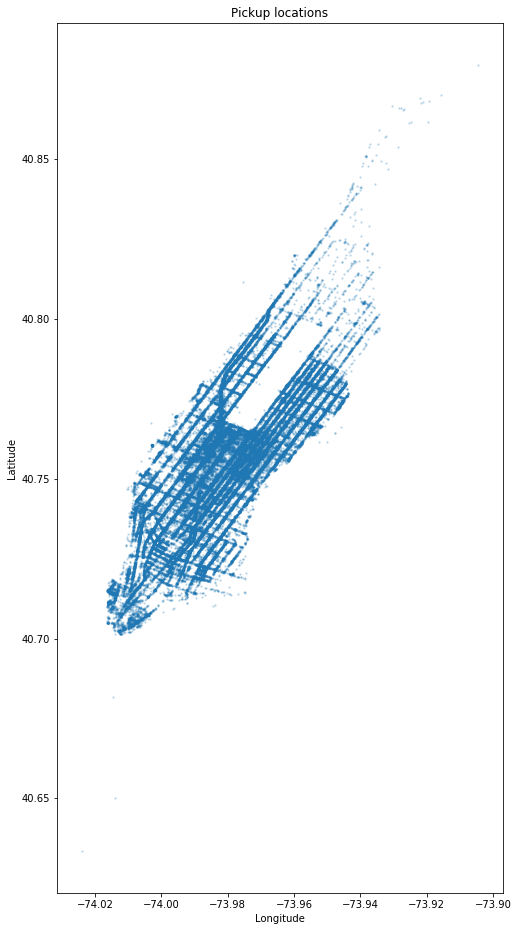

In [29]:
polygon = pd.read_csv('manhattan.csv')

# Recommended: First develop and test a function that takes a position
#              and returns whether it's in Manhattan.
#
def in_manhattan(x, y):
    
    tf = []
    x = x.tolist()
    y = y.tolist()
   
    
    for k in range(len(x)):
        if (x[k] < 40.700292 and y[k] > -74.010773):
            tf.append(0)
        elif x[k] <40.707580 and y[k] > -73.999271:
            tf.append(0)
        elif x[k] < 40.710443 and y[k] > -73.978758:
            tf.append(0)

        elif x[k] <40.721762 and y[k] > -73.971977:
            tf.append(0)

        elif x[k] < 40.729568 and y[k] >  -73.971291:
            tf.append(0)

        elif x[k] < 40.733503 and y[k] > -73.973994:
            tf.append(0)

        elif x[k] < 40.746834 and y[k] > -73.968072:
            tf.append(0)
        elif x[k] < 40.758546 and y[k] > -73.958081:
            tf.append(0)
        elif x[k] <40.774707 and y[k]> -73.942886:
            tf.append(0)
        elif x[k] < 40.775114 and y[k] > -73.941936:
            tf.append(0)

        elif x[k]  < 40.778884 and y[k] > -73.942580:
            tf.append(0)

        elif x[k] < 40.781906 and y[k] > -73.943589:
            tf.append(0)

        elif x[k] < 40.785351 and y[k] > -73.939362:
            tf.append(0)

        elif x[k] < 40.789640 and y[k] > -73.936272:
            tf.append(0)

        elif x[k] < 40.793149 and y[k] > -73.932238:
            tf.append(0)

        elif x[k]< 40.795228 and y[k] > -73.929491:
            tf.append(0)

        elif x[k] < 40.801141 and y[k] > -73.928976:
            tf.append(0)

        elif x[k] < 40.804877 and y[k] > -73.930907:
            tf.append(0)

        elif x[k] < 40.810496 and y[k] > -73.934298:
            tf.append(0)

        elif x[k] < 40.834074 and y[k] >-73.934383:
            tf.append(0)

        elif x[k] < 40.855371 and y[k] > -73.922281:
            tf.append(0)

        elif x[k] < 40.870690 and y[k] > -73.908892:
            tf.append(0)

        elif x[k] > 40.878348 and y[k] < -73.928289:
            tf.append(0)

        elif x[k] >  40.851151 and y[k] < -73.947258:
            tf.append(0)

        elif x[k] > 40.844074 and y[k] < -73.947086:
            tf.append(0)

        elif x[k] > 40.828229 and y[k] < -73.955498:
            tf.append(0)

        elif x[k] > 40.754019 and y[k] < -74.008713:
            tf.append(0)

        elif x[k] > 40.719941 and y[k] < -74.013863:
            tf.append(0)

        elif x[k] > 40.718575 and y[k] < -74.013605:
            tf.append(0)

        elif x[k] > 40.718802 and y[k] < -74.017038:
            tf.append(0)

        elif x[k] > 40.704977 and y[k] < -74.020042:
            tf.append(0)

        elif x[k] > 40.700553 and y[k] <-74.016438:
            tf.append(0)

        else:
            tf.append(1)
#     tf = pd.DataFrame(tf, columns =['is_m'])
    return tf
        

    """Whether a longitude-latitude (x, y) pair is in the Manhattan polygon."""

    
# Recommended: Then, apply this function to every trip to filter clean_taxi.
manhttan_taxi = clean_taxi.copy(deep=True)
pickup = in_manhattan(manhttan_taxi.pickup_lat,manhttan_taxi.pickup_lon)
manhttan_taxi["in_manhttan_pick"] = pickup
dropoff = in_manhattan(manhttan_taxi.dropoff_lat,manhttan_taxi.dropoff_lon)
manhttan_taxi["in_manhttan_drop"] = dropoff
clean_taxi.head()


indexNames = manhttan_taxi[ manhttan_taxi['in_manhttan_pick'] == 0 ].index

manhttan_taxi.drop(indexNames , inplace=True)

indexNames = manhttan_taxi[ manhttan_taxi['in_manhttan_drop'] == 0 ].index
manhttan_taxi.drop(indexNames , inplace=True)

manhattan_taxi = manhttan_taxi.drop(['in_manhttan_drop','in_manhttan_pick'], axis=1)


plt.figure(figsize=(8, 16))
pickup_scatter(manhattan_taxi)


In [30]:
ok.grade("q1c");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
q1c > Suite 1 > Case 1

>>> manhattan_taxi.shape
(82499, 9)

# Error: expected
#     (82800, 9)
# but got
#     (82499, 9)

Run only this test case with "python3 ok -q q1c --suite 1 --case 1"
---------------------------------------------------------------------
Test summary
    Passed: 0
    Failed: 1
[k..........] 0.0% passed



If you are unable to solve the problem above, have trouble with the tests, or want to work on the rest of the project before solving it, run the following cell to load the cleaned Manhattan data directly. (Note that you may not solve the previous problem just by loading this data file; you have to actually write the code.)

In [31]:
manhattan_taxi = pd.read_csv('manhattan_taxi.csv')

A scatter diagram of only Manhattan taxi rides has the familiar shape of Manhattan Island. 

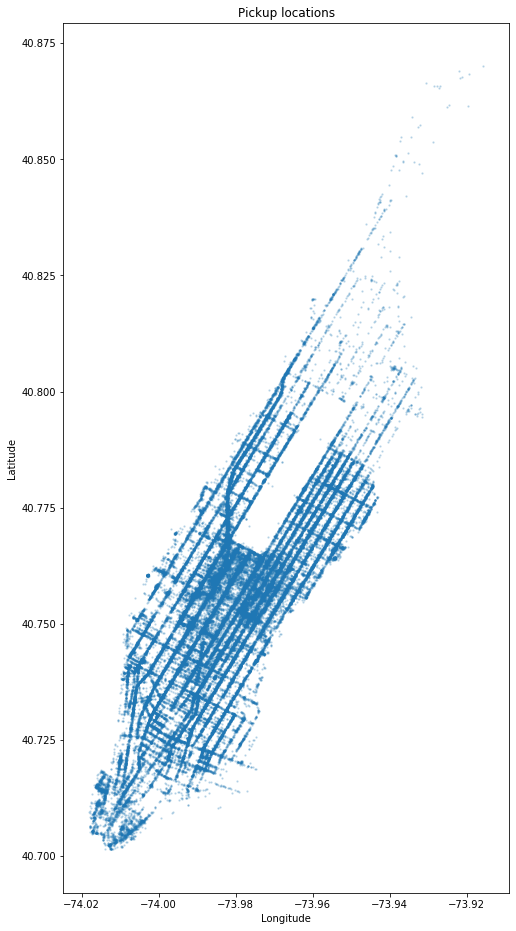

In [32]:
plt.figure(figsize=(8, 16))
pickup_scatter(manhattan_taxi)

### Question 1d

Print a summary of the data selection and cleaning you performed. **Your Python code should not include any number literals, but instead should refer to the shape of `all_taxi`, `clean_taxi`, and `manhattan_taxi`**.

E.g., you should print something like: "Of the original 1000 trips, 21 anomalous trips (2.1%) were removed through data cleaning, and then the 600 trips within Manhattan were selected for further analysis."

(Note that the numbers in the example above are not accurate.)

One way to do this is with Python's f-strings. For instance,
``` python
name = "Joshua"
print(f"Hi {name}, how are you?")
```
prints out `Hi Joshua, how are you?.`

**Please ensure that your Python code does not contain any very long lines, or we can't grade it.**

*Your response will be scored based on whether you generate an accurate description and do not include any number literals in your Python expression, but instead refer to the dataframes you have created.*

<!--
BEGIN QUESTION
name: q1d
points: 2
manual: True
-->
<!-- EXPORT TO PDF -->

In [12]:
print(all_taxi.shape)
print(clean_taxi.shape)
print(manhattan_taxi.shape)

clean_taxi.head()

allTaxiCount = all_taxi.shape
allTaxiCount = np.array(allTaxiCount).tolist()

cleanTaxiCount = clean_taxi.shape
cleanTaxiCount = np.array(cleanTaxiCount).tolist()

manhattan_taxiCount= manhattan_taxi.shape
manhattan_taxiCount = np.array(manhattan_taxiCount).tolist()

print("Of the original ",allTaxiCount[0], " trips, ", allTaxiCount[0] -cleanTaxiCount[0], " anomalous trips",end=" ")
ans = (allTaxiCount[0] -cleanTaxiCount[0])/allTaxiCount[0] 
ans = ans * 100

print("(", round(ans,2),"% ) of were removed through data cleaning, and then ", end="")
print(manhattan_taxiCount[0], " of the data manhatta's data are selected for further analysis")

(97692, 9)
(96445, 9)
(82800, 9)
Of the original  97692  trips,  1247  anomalous trips ( 1.28 % ) of were removed through data cleaning, and then 82800  of the data manhatta's data are selected for further analysis


## Part 2: Exploratory Data Analysis

In this part, you'll choose which days to include as training data in your regression model. 

Your goal is to develop a general model that could potentially be used for future taxi rides. There is no guarantee that future distributions will resemble observed distributions, but some effort to limit training data to typical examples can help ensure that the training data are representative of future observations.

January 2016 had some atypical days. New Year's Day (January 1) fell on a Friday. MLK Day was on Monday, January 18. A [historic blizzard](https://en.wikipedia.org/wiki/January_2016_United_States_blizzard) passed through New York that month. Using this dataset to train a general regression model for taxi trip times must account for these unusual phenomena, and one way to account for them is to remove atypical days from the training data.

### Question 2a

Add a column labeled `date` to `manhattan_taxi` that contains the date (but not the time) of pickup, formatted as a `datetime.date` value ([docs](https://docs.python.org/3/library/datetime.html#date-objects)). 

*The provided tests check that you have extended `manhattan_taxi` correctly.*

<!--
BEGIN QUESTION
name: q2a
points: 1
-->

In [33]:


manhattan_taxi["date"]=manhattan_taxi.pickup_datetime
manhattan_taxi["date"]=pd.to_datetime(manhattan_taxi.date, format='%Y-%m-%d %H:%M:%S')
manhattan_taxi["date"]=manhattan_taxi["date"].dt.date

In [34]:
ok.grade("q2a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 2b

Create a data visualization that allows you to identify which dates were affected by the historic blizzard of January 2016. Make sure that the visualization type is appropriate for the visualized data.

As a hint, consider how taxi usage might change on a day with a blizzard. How could you visualize/plot this?

<!--
BEGIN QUESTION
name: q2b
points: 2
manual: True
format: image
-->
<!-- EXPORT TO PDF -->

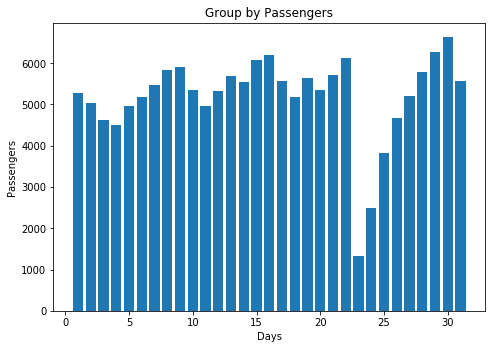

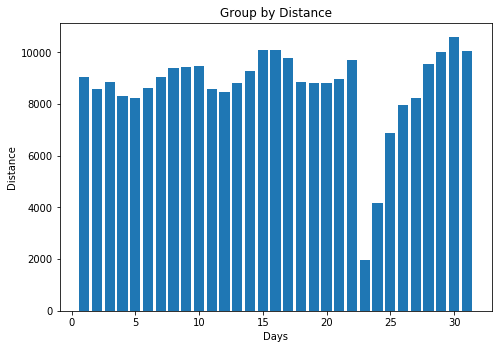

In [35]:

import numpy as np
import matplotlib.pyplot as plt

visualization = clean_taxi.copy(deep="True")

visualization["date"]=visualization.pickup_datetime
visualization["date"]=pd.to_datetime(visualization.date, format='%Y-%m-%d %H:%M:%S')
visualization= visualization.drop(['pickup_datetime','dropoff_datetime'], axis=1)
# strftime('%m%d')
visualization["date"] = visualization["date"].dt.day

visualization = visualization.groupby(['date']).sum()

fig = plt.figure()
ax = fig.add_axes(([0,0,1,1]))
x =  list(range(32))
x.pop(0)
y =  visualization["passengers"]
y = y.values.tolist()

# y = pd.DataFrame(y)
# x = pd.DataFrame(x)
# print(x.shape)
# print (y.shape)#
ax.set_title ('Group by Passengers')
ax.set_ylabel('Passengers')
ax.set_xlabel('Days')
ax.bar(x,y)
plt.show()



visualization = clean_taxi.copy(deep="True")

visualization["date"]=visualization.pickup_datetime
visualization["date"]=pd.to_datetime(visualization.date, format='%Y-%m-%d %H:%M:%S')
visualization= visualization.drop(['pickup_datetime','dropoff_datetime'], axis=1)
# strftime('%m%d')
visualization["date"] = visualization["date"].dt.day

visualization = visualization.groupby(['date']).sum()

fig = plt.figure()
ax = fig.add_axes(([0,0,1,1]))
x =  list(range(32))
x.pop(0)

y =  visualization["distance"]
y = y.values.tolist()

ax.set_title ('Group by Distance')
ax.set_ylabel('Distance')
ax.set_xlabel('Days')
ax.bar(x,y)
plt.show()



Finally, we have generated a list of dates that should have a fairly typical distribution of taxi rides, which excludes holidays and blizzards. The cell below assigns `final_taxi` to the subset of `manhattan_taxi` that is on these days. (No changes are needed; just run this cell.)

In [36]:
import calendar
import re

from datetime import date

atypical = [1, 2, 3, 18, 23, 24, 25, 26]
typical_dates = [date(2016, 1, n) for n in range(1, 32) if n not in atypical]
typical_dates

print('Typical dates:\n')
pat = '  [1-3]|18 | 23| 24|25 |26 '
print(re.sub(pat, '   ', calendar.month(2016, 1)))

final_taxi = manhattan_taxi[manhattan_taxi['date'].isin(typical_dates)]

Typical dates:

    January 2016
Mo Tu We Th Fr Sa Su
                    
 4  5  6  7  8  9 10
11 12 13 14 15 16 17
   19 20 21 22      
      27 28 29 30 31



You are welcome to perform more exploratory data analysis, but your work will not be scored. Here's a blank cell to use if you wish. In practice, further exploration would be warranted at this point, but the project is already pretty long.

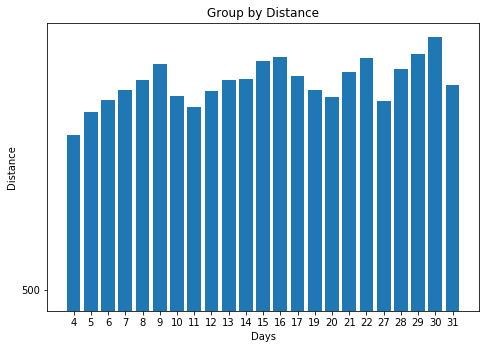

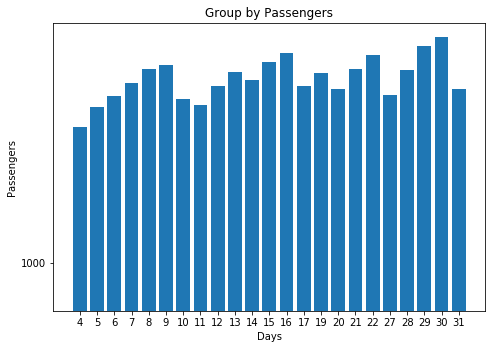

In [37]:
visualization = final_taxi.copy(deep="True")

visualization["date"]=visualization.pickup_datetime
visualization["date"]=pd.to_datetime(visualization.date, format='%Y-%m-%d %H:%M:%S')
visualization= visualization.drop(['pickup_datetime','dropoff_datetime'], axis=1)
# strftime('%m%d')
visualization["date"] = visualization["date"].dt.day

visualization = visualization.groupby(['date']).sum()

fig = plt.figure()
ax = fig.add_axes(([0,0,1,1]))
x =  list(range(32))

x.remove(0)
x.remove(1)
x.remove(2)
x.remove(3)
x.remove(18)
x.remove(23)
x.remove(24)
x.remove(25)
x.remove(26)


y =  visualization["distance"]
y = y.values.tolist()

ind = np.arange(23)

p1 = plt.bar(ind,y,linewidth = 4)

plt.ylabel('Distance')
plt.title('Group by Distance')
plt.xlabel('Days')
plt.xticks(ind, x)
ind = np.arange(500,4000,6000)
plt.yticks(ind)




plt.show()



visualization = final_taxi.copy(deep="True")

visualization["date"]=visualization.pickup_datetime
visualization["date"]=pd.to_datetime(visualization.date, format='%Y-%m-%d %H:%M:%S')
visualization= visualization.drop(['pickup_datetime','dropoff_datetime'], axis=1)
# strftime('%m%d')
visualization["date"] = visualization["date"].dt.day

visualization = visualization.groupby(['date']).sum()

fig = plt.figure()
ax = fig.add_axes(([0,0,1,1]))
x =  list(range(32))

x.remove(0)
x.remove(1)
x.remove(2)
x.remove(3)
x.remove(18)
x.remove(23)
x.remove(24)
x.remove(25)
x.remove(26)


y =  visualization["passengers"]
y = y.values.tolist()

ind = np.arange(23)
width = 0.40
p1 = plt.bar(ind,y,linewidth = 4)

plt.ylabel('Passengers')
plt.title('Group by Passengers')
plt.xlabel('Days')
plt.xticks(ind, x)
ind = np.arange(1000,5000, 6000)
plt.yticks(ind)




plt.show()

## Part 3: Feature Engineering

In this part, you'll create a design matrix (i.e., feature matrix) for your linear regression model. This is analagous to the pipelines you've built already in class: you'll be adding features, removing labels, and scaling among other things.

You decide to predict trip duration from the following inputs: start location, end location, trip distance, time of day, and day of the week (*Monday, Tuesday, etc.*).

You will ensure that the process of transforming observations into a design matrix is expressed as a Python function called `design_matrix`, so that it's easy to make predictions for different samples in later parts of the project.

Because you are going to look at the data in detail in order to define features, it's best to split the data into training and test sets now, then only inspect the training set.

In [38]:
import sklearn.model_selection

train, test = sklearn.model_selection.train_test_split(
    final_taxi, train_size=0.8, test_size=0.2, random_state=42)
print('Train:', train.shape, 'Test:', test.shape)

Train: (53680, 10) Test: (13421, 10)


### Question 3a

Create a box plot that compares the distributions of taxi trip durations for each day **using `train` only**. Individual dates shoud appear on the horizontal axis, and duration values should appear on the vertical axis. Your plot should look like the one below.

You can generate this type of plot using `sns.boxplot`

![](images/3a_duration_by_date.png)


<!--
BEGIN QUESTION
name: q3a
points: 2
manual: True
format: image
-->
<!-- EXPORT TO PDF -->

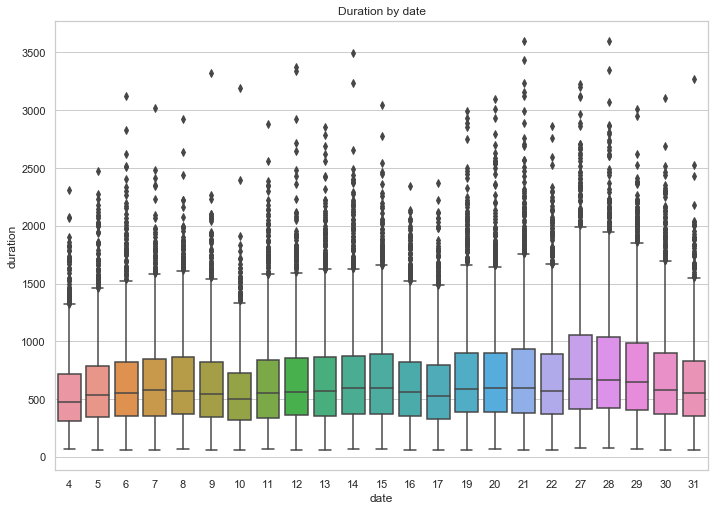

In [39]:
import seaborn as sns

box_dia = train.copy(deep="True")
sns.set(style="whitegrid")
box_dia["date"]=box_dia.pickup_datetime


box_dia["date"]=pd.to_datetime(box_dia.date, format='%Y-%m-%d %H:%M:%S')
box_dia= box_dia.drop(['pickup_datetime','dropoff_datetime'], axis=1)

box_dia["date"] = box_dia["date"].dt.day



sns.set(style="whitegrid")

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.boxplot(x=box_dia["date"], y=box_dia["duration"], ax= ax)
ax.set_title("Duration by date")


plt.show()


### Question 3b

In one or two sentences, describe the assocation between the day of the week and the duration of a taxi trip. Your answer should be supported by your boxplot above.

*Note*: The end of Part 2 showed a calendar for these dates and their corresponding days of the week.

<!--
BEGIN QUESTION
name: q3b
points: 1
manual: True
-->
<!-- EXPORT TO PDF -->






The median of duration of taxi trip is lower in weekends than in weekdays.




Below, the provided `augment` function adds various columns to a taxi ride dataframe. 

- `hour`: The integer hour of the pickup time. E.g., a 3:45pm taxi ride would have `15` as the hour. A 12:20am ride would have `0`.
- `day`: The day of the week with Monday=0, Sunday=6.
- `weekend`: 1 if and only if the `day` is Saturday or Sunday.
- `period`: 1 for early morning (12am-6am), 2 for daytime (6am-6pm), and 3 for night (6pm-12pm).
- `speed`: Average speed in miles per hour.

No changes are required; just run this cell.

In [40]:
def speed(t):
    """Return a column of speeds in miles per hour."""
    return t['distance'] / t['duration'] * 60 * 60

def augment(t):
    """Augment a dataframe t with additional columns."""
    u = t.copy()
    pickup_time = pd.to_datetime(t['pickup_datetime'])
    u.loc[:, 'hour'] = pickup_time.dt.hour
    u.loc[:, 'day'] = pickup_time.dt.weekday
    u.loc[:, 'weekend'] = (pickup_time.dt.weekday >= 5).astype(int)
    u.loc[:, 'period'] = np.digitize(pickup_time.dt.hour, [0, 6, 18])
    u.loc[:, 'speed'] = speed(t)
    
    return u
    
train = augment(train)
test = augment(test)
train.iloc[0,:] # An example row

pickup_datetime     2016-01-21 18:02:20
dropoff_datetime    2016-01-21 18:27:54
pickup_lon                     -73.9942
pickup_lat                       40.751
dropoff_lon                    -73.9637
dropoff_lat                     40.7711
passengers                            1
distance                           2.77
duration                           1534
date                         2016-01-21
hour                                 18
day                                   3
weekend                               0
period                                3
speed                           6.50065
Name: 14043, dtype: object

### Question 3c

Use `sns.distplot` to create an overlaid histogram comparing the distribution of average speeds for taxi rides that start in the early morning (12am-6am), day (6am-6pm; 12 hours), and night (6pm-12am; 6 hours). Your plot should look like this:

![](images/3c_speeds.png)

<!--
BEGIN QUESTION
name: q3c
points: 2
manual: True
format: image
-->
<!-- EXPORT TO PDF -->

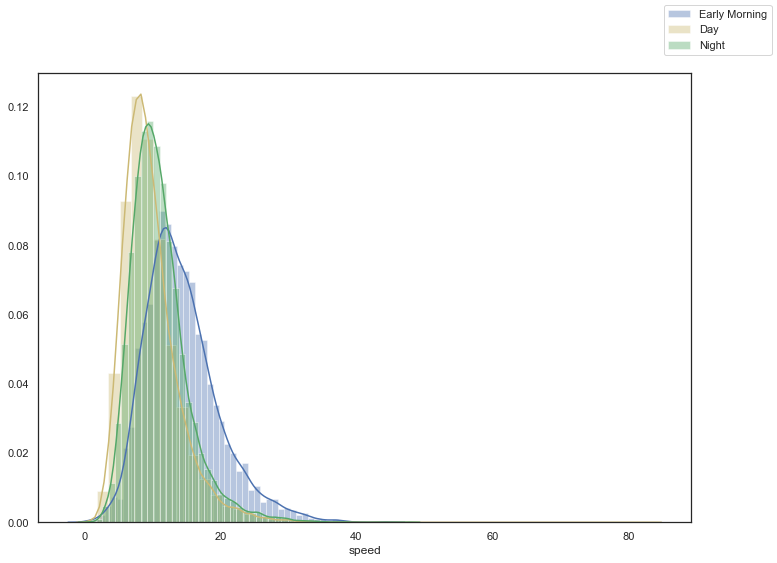

In [41]:

sns.set(style="white")

fig, ax = plt.subplots()

fig.set_size_inches(11.7, 8.27)

Morning= train.loc[train["period"] == 1]
Day= train.loc[train["period"] == 2]
Night= train.loc[train["period"] == 3]

sns.distplot(Morning["speed"],color = 'b', label = 'Early Morning', ax=ax)
sns.distplot(Day["speed"],color = 'y', label = 'Day', ax=ax)
sns.distplot(Night["speed"],color = 'g', label = 'Night', ax=ax)

fig.legend(labels=['Early Morning', 'Day', 'Night'])




plt.show()

It looks like the time of day is associated with the average speed of a taxi ride.

### Question 3d

Manhattan can roughly be divided into Lower, Midtown, and Upper regions. Instead of studying a map, let's approximate by finding the first principal component of the pick-up location (latitude and longitude). 

[Principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) is a technique that finds new axes as linear combinations of your current axes. These axes are found such that the first returned axis (the first principal component) explains the most variation in values, the 2nd the second most, etc.

Add a `region` column to `train` that categorizes each pick-up location as 0, 1, or 2 based on the value of each point's first principal component, such that an equal number of points fall into each region. 

Read the documentation of [`pd.qcut`](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.qcut.html), which categorizes points in a distribution into equal-frequency bins.

You don't need to add any lines to this solution. Just fill in the assignment statements to complete the implementation.

Before implementing PCA, it is important to scale and shift your values. The line with `np.linalg.svd` will return your transformation matrix, among other things. You can then use this matrix to convert points in (lat, lon) space into (PC1, PC2) space.

*The provided tests ensure that you have answered the question correctly.*

<!--
BEGIN QUESTION
name: q3d
points: 2
-->

In [42]:
# Find the first principle component
D = train[['pickup_lon', 'pickup_lat']]
pca_n = len(D)
pca_means = np.mean(D)
X = (D - pca_means) / np.sqrt(pca_n)
u, s, vt = np.linalg.svd(X, full_matrices=False)

def add_region(t):
    """Add a region column to t based on vt above."""
    D = t[['pickup_lon', 'pickup_lat']]
    assert D.shape[0] == t.shape[0], 'You set D using the incorrect table'
    # Always use the same data transformation used to compute vt
    X = (D - pca_means) / np.sqrt(pca_n) 
    first_pc = X @ vt.transpose()[0]
    t.loc[:,'region'] = pd.qcut(first_pc, 3, labels=[0, 1, 2])
    
add_region(train)
add_region(test)

In [43]:
ok.grade("q3d");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 7
    Failed: 0
[ooooooooook] 100.0% passed



Let's see how PCA divided the trips into three groups. These regions do roughly correspond to Lower Manhattan (below 14th street), Midtown Manhattan (between 14th and the park), and Upper Manhattan (bordering Central Park). No prior knowledge of New York geography was required!

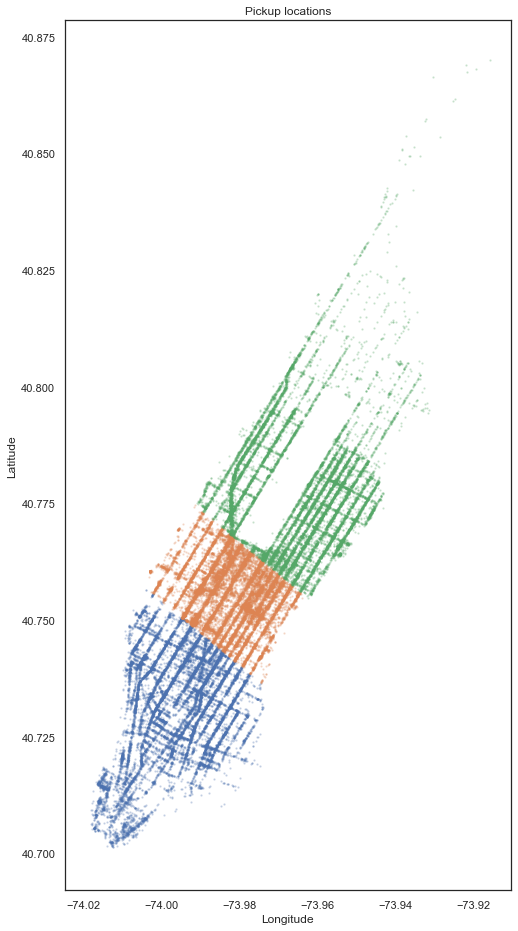

In [44]:
plt.figure(figsize=(8, 16))
for i in [0, 1, 2]:
    pickup_scatter(train[train['region'] == i])

### Question 3e (ungraded)

Use `sns.distplot` to create an overlaid histogram comparing the distribution of speeds for nighttime taxi rides (6pm-12am) in the three different regions defined above. Does it appear that there is an association between region and average speed during the night?

In [ ]:
...

Finally, we create a design matrix that includes many of these features. Quantitative features are converted to standard units, while categorical features are converted to dummy variables using one-hot encoding. The `period` is not included because it is a linear combination of the `hour`. The `weekend` variable is not included because it is a linear combination of the `day`.  The `speed` is not included because it was computed from the `duration`; it's impossible to know the speed without knowing the duration, given that you know the distance.

In [45]:
from sklearn.preprocessing import StandardScaler

num_vars = ['pickup_lon', 'pickup_lat', 'dropoff_lon', 'dropoff_lat', 'distance']
cat_vars = ['hour', 'day', 'region']

scaler = StandardScaler()
scaler.fit(train[num_vars])

def design_matrix(t):
    """Create a design matrix from taxi ride dataframe t."""
    scaled = t[num_vars].copy()
    scaled.iloc[:,:] = scaler.transform(scaled) # Convert to standard units
    categoricals = [pd.get_dummies(t[s], prefix=s, drop_first=True) for s in cat_vars]
    return pd.concat([scaled] + categoricals, axis=1)

# This processes the full train set, then gives us the first item
# Use this function to get a processed copy of the dataframe passed in
# for training / evaluation
design_matrix(train).iloc[0,:]  

pickup_lon    -0.805821
pickup_lat    -0.171761
dropoff_lon    0.954062
dropoff_lat    0.624203
distance       0.626326
hour_1         0.000000
hour_2         0.000000
hour_3         0.000000
hour_4         0.000000
hour_5         0.000000
hour_6         0.000000
hour_7         0.000000
hour_8         0.000000
hour_9         0.000000
hour_10        0.000000
hour_11        0.000000
hour_12        0.000000
hour_13        0.000000
hour_14        0.000000
hour_15        0.000000
hour_16        0.000000
hour_17        0.000000
hour_18        1.000000
hour_19        0.000000
hour_20        0.000000
hour_21        0.000000
hour_22        0.000000
hour_23        0.000000
day_1          0.000000
day_2          0.000000
day_3          1.000000
day_4          0.000000
day_5          0.000000
day_6          0.000000
region_1       1.000000
region_2       0.000000
Name: 14043, dtype: float64

## Part 4: Model Selection

In this part, you will select a regression model to predict the duration of a taxi ride.

**Important:** *Tests in this part do not confirm that you have answered correctly. Instead, they check that you're somewhat close in order to detect major errors. It is up to you to calculate the results correctly based on the question descriptions.*

### Question 4a

Assign `constant_rmse` to the root mean squared error on the **test** set for a constant model that always predicts the mean duration of all **training set** taxi rides.

<!--
BEGIN QUESTION
name: q4a
points: 2
-->

In [46]:
def rmse(errors):
    """Return the root mean squared error."""
    return np.sqrt(np.mean(errors ** 2))



constant_rmse = rmse(test['duration'] - np.mean(train['duration']))
constant_rmse 

399.1437572352677

In [48]:
ok.grade("q4a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Question 4b

Assign `simple_rmse` to the root mean squared error on the test set for a simple linear regression model that uses only the distance of the taxi ride as a feature (and includes an intercept).

*Terminology Note*: Simple linear regression means that there is only one covariate. Multiple linear regression means that there is more than one. In either case, you can use the `LinearRegression` model from `sklearn` to fit the parameters to data.

<!--
BEGIN QUESTION
name: q4b
points: 2
-->

In [49]:
train.head()

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration,date,hour,day,weekend,period,speed,region
14043,2016-01-21 18:02:20,2016-01-21 18:27:54,-73.994202,40.751019,-73.963692,40.771069,1,2.77,1534,2016-01-21,18,3,0,3,6.500652,1
9122,2016-01-29 06:18:36,2016-01-29 06:21:32,-73.990402,40.756344,-73.984161,40.761757,3,0.69,176,2016-01-29,6,4,0,2,14.113636,1
9291,2016-01-04 20:34:21,2016-01-04 20:42:33,-74.006554,40.732922,-74.001175,40.751366,1,1.60,492,2016-01-04,20,0,0,3,11.707317,0
76214,2016-01-09 12:12:58,2016-01-09 12:20:26,-73.992065,40.750313,-73.982803,40.755829,1,0.90,448,2016-01-09,12,5,1,2,7.232143,1
46314,2016-01-13 10:57:45,2016-01-13 11:02:06,-73.959358,40.771824,-73.964661,40.770443,1,0.40,261,2016-01-13,10,2,0,2,5.517241,2


In [52]:
Train1 = train[["distance", "duration"]]
Test1 = test[["distance", "duration"]]

X_train = Train1["distance"]
y_train = Train1["duration"]

X_test = Test1["distance"]
y_test = Test1["duration"]


X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)


X_train = np.reshape(X_train, (-1, 1))
y_train =np.reshape(y_train, (-1, 1))


X_test = np.reshape(X_test, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()


model.fit(X_train, y_train)

y_pred = model.predict(X_test)
simple_rmse = np.sqrt(mean_squared_error(y_test, y_pred))


In [54]:
ok.grade("q4b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Question 4c

Assign `linear_rmse` to the root mean squared error on the test set for a linear regression model fitted to the training set without regularization, using the design matrix defined by the `design_matrix` function from Part 3.

*The provided tests check that you have answered the question correctly and that your `design_matrix` function is working as intended.*

<!--
BEGIN QUESTION
name: q4c
points: 2
-->

In [55]:
X_train =  design_matrix(train)
X_test = design_matrix(test)

print ("x train shape, ",X_train.shape)
print ("y train shape, ",y_train.shape)

print ("x test shape, ",X_test.shape)
print ("y test shape, ",y_test.shape)




x train shape,  (53680, 36)
y train shape,  (53680, 1)
x test shape,  (13421, 36)
y test shape,  (13421, 1)


In [56]:
model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
linear_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
linear_rmse

255.19146631882757

In [57]:
ok.grade("q4c");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



### Question 4d

For each possible value of `period`, fit an unregularized linear regression model to the subset of the training set in that `period`.  Assign `period_rmse` to the root mean squared error on the test set for a model that first chooses linear regression parameters based on the observed period of the taxi ride, then predicts the duration using those parameters. Again, fit to the training set and use the `design_matrix` function for features.

<!--
BEGIN QUESTION
name: q4d
points: 2
-->

In [58]:
X_train =  design_matrix(train)
X_test = design_matrix(test)

X_train.head()


,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,distance,hour_1,hour_2,hour_3,hour_4,hour_5,...,hour_22,hour_23,day_1,day_2,day_3,day_4,day_5,day_6,region_1,region_2
14043,-0.805821,-0.171761,0.954062,0.624203,0.626326,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
9122,-0.570281,0.077978,-0.231391,0.234068,-0.826569,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
9291,-1.571566,-1.020443,-1.216691,-0.201297,-0.190927,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76214,-0.673389,-0.204856,-0.152744,-0.014301,-0.679882,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
46314,1.354249,0.803938,0.897948,0.597992,-1.029136,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [59]:
model = LinearRegression()
errors = []

for v in np.unique(train['period']):
    model.fit(design_matrix(train[train['period']==v]),train[train['period']==v].loc[:, "duration"])
    errors.append(test[test['period']==v]["duration"]- model.predict(design_matrix(test[test['period']==v])))


period_rmse = rmse(pd.concat(errors))
period_rmse

246.6286883116511

In [60]:
print (model.predict(design_matrix(test[test['period']==1])))

[1262.54646559  235.39994397  915.80463226 ...  801.57169625  651.00512227
  444.5215262 ]


In [61]:
print(test[test['period']==v]["duration"])

7187     1033
4515      455
21291    1296
341       268
34652    1083
         ... 
35160     689
48512     571
27657     195
31709    1077
40574     927
Name: duration, Length: 4572, dtype: int64


In [62]:
ok.grade("q4d");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



This approach is a simple form of decision tree regression, where a different regression function is estimated for each possible choice among a collection of choices. In this case, the depth of the tree is only 1.

### Question 4e

In one or two sentences, explain how the `period` regression model above could possibly outperform linear regression when the design matrix for linear regression already includes one feature for each possible hour, which can be combined linearly to determine the `period` value.

<!--
BEGIN QUESTION
name: q4e
points: 2
manual: True
-->
<!-- EXPORT TO PDF -->

The "period" feature are distinguished by labeling 1,2,3, which influences the parameter because 1,2,3, are just labels. But this method treat 1,2,3 fairly



### Question 4f

Instead of predicting duration directly, an alternative is to predict the average *speed* of the taxi ride using linear regression, then compute an estimate of the duration from the predicted speed and observed distance for each ride.

Assign `speed_rmse` to the root mean squared error in the **duration** predicted by a model that first predicts speed as a linear combination of features from the `design_matrix` function, fitted on the training set, then predicts duration from the predicted speed and observed distance.

*Hint*: Speed is in miles per hour, but duration is measured in seconds. You'll need the fact that there are 60 * 60 = 3,600 seconds in an hour.

<!--
BEGIN QUESTION
name: q4f
points: 2
-->

In [63]:
model = LinearRegression()

model.fit(design_matrix(train),train.loc[:,'speed'])

solve = test['distance']/test['speed']*3600
solve2 = test['distance']/(model.predict(design_matrix(test)))*3600
speed_rmse = rmse(solve - solve2)
speed_rmse

243.01798368514977

In [64]:
ok.grade("q4f");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



*Optional*: Explain why predicting speed leads to a more accurate regression model than predicting duration directly. You don't need to write this down.

### Question 4g

Finally, complete the function `tree_regression_errors` (and helper function `speed_error`) that combines the ideas from the two previous models and generalizes to multiple categorical variables.

The `tree_regression_errors` should:
- Find a different linear regression model for each possible combination of the variables in `choices`;
- Fit to the specified `outcome` (on train) and predict that `outcome` (on test) for each combination (`outcome` will be `'duration'` or `'speed'`);
- Use the specified `error_fn` (either `duration_error` or `speed_error`) to compute the error in predicted duration using the predicted outcome;
- Aggregate those errors over the whole test set and return them.

You should find that including each of `period`, `region`, and `weekend` improves prediction accuracy, and that predicting speed rather than duration leads to more accurate duration predictions.

If you're stuck, try putting print statements in the skeleton code to see what it's doing.

<!--
BEGIN QUESTION
name: q4g
points: 4
-->

In [65]:
model = LinearRegression()
choices = ['period', 'region', 'weekend']

def duration_error(predictions, observations):
    """Error between duration predictions (array) and observations (data frame)"""
    return predictions - observations['duration']

def speed_error(predictions, observations):
    """Duration error between speed predictions and duration observations"""
    return duration_error(observations['distance']/predictions*3600, observations)

def tree_regression_errors(outcome='duration', error_fn=duration_error):
    """Return errors for all examples in test using a tree regression model."""
    errors = []
    for vs in train.groupby(choices).size().index:
        v_train, v_test = train, test
        for v, c in zip(vs, choices):
            v_train = v_train[v_train[c]==v]
            v_test = v_test[v_test[c]==v]
        model.fit(design_matrix(v_train), v_train.loc[:,outcome])
        error= error_fn(model.predict(design_matrix(v_test)),v_test)
        errors.append(error)
    return errors

errors = tree_regression_errors()
errors_via_speed = tree_regression_errors('speed', speed_error)
tree_rmse = rmse(pd.concat(errors))
tree_speed_rmse = rmse(pd.concat(errors_via_speed))
print('Duration:', tree_rmse, '\nSpeed:', tree_speed_rmse)

Duration: 240.33952192703526 
Speed: 226.90793945018333


In [66]:
ok.grade("q4g");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



Here's a summary of your results:

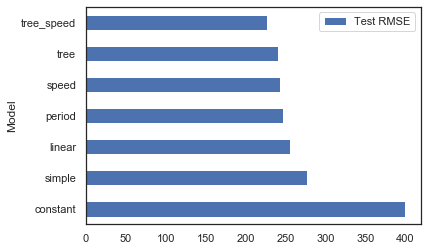

In [67]:
models = ['constant', 'simple', 'linear', 'period', 'speed', 'tree', 'tree_speed']
pd.DataFrame.from_dict({
    'Model': models,
    'Test RMSE': [eval(m + '_rmse') for m in models]
}).set_index('Model').plot(kind='barh');

## Part 5: Building on your own

In this part you'll build a regression model of your own design, with the goal of achieving even higher performance than you've seen already. You will be graded on your performance relative to others in the class, with higher performance (lower RMSE) receiving more points.



### Question 5a

In the below cell (feel free to add your own additional cells), train a regression model of your choice on the same train dataset split used above. The model can incorporate anything you've learned from the class so far.

The model you train will be used for questions 5b and 5c

In [68]:
X_train =  design_matrix(train)
X_test = design_matrix(test)


y_train = train["duration"]
y_test = test["duration"]



num_features = len(X_train.columns)


In [69]:
from sklearn.model_selection import train_test_split


X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5)
    

In [70]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Dense
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling



/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passi

In [72]:

c = 64


model = keras. Sequential([
    layers.Dense(c, activation = 'relu', input_shape = (num_features,)),
    layers.Dense(c, activation = 'relu'), 
    layers.Dense(1),
    
])


optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile(optimizer=optimizer ,
              loss='mse',
              metrics=['mae', 'mse'])

model.summary()
# model.fit(X_train, y_train ,batch_size = 32, epochs = 100,
#          validation_data= (X_test, y_test))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                2368      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 6,593
Trainable params: 6,593
Non-trainable params: 0
_________________________________________________________________


In [75]:
history = model.fit(X_train, y_train ,batch_size = c, epochs = 50,
          validation_split = 0.2, verbose=0, 
         callbacks=[tfdocs.modeling.EpochDots()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


Epoch: 0, loss:42222.5857,  mean_absolute_error:141.5869,  mean_squared_error:42222.5547,  val_loss:40826.9385,  val_mean_absolute_error:141.5948,  val_mean_squared_error:40826.9453,  
..................................................

In [76]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape = (num_features,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

In [77]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
early_history = model.fit(X_train, y_train, 
                    epochs=100, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:37465.3514,  mean_absolute_error:133.7458,  mean_squared_error:37465.3281,  val_loss:37102.9241,  val_mean_absolute_error:134.6404,  val_mean_squared_error:37102.9258,  
...................................................

In [78]:
y_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
y_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred))

### Question 5b

Print a summary of your model's performance. You **must** include the RMSE on the train and test sets. Do not hardcode any values or you won't receive credit.

Don't include any long lines or we won't be able to grade your response.

<!--
BEGIN QUESTION
name: q5b
points: 7
manual: True
-->
<!-- EXPORT TO PDF -->

In [79]:
print("Test RMSE = " ,test_rmse)
print("Train RMSE = " ,train_rmse)

Test RMSE =  203.15505756666695
Train RMSE =  189.96678277803375


### Question 5c
Describe why you selected the model you did and what you did to try and improve performance over the models in section 4.

Responses should be at most a few sentences

<!--
BEGIN QUESTION
name: q5c
points: 3
manual: True
-->
<!-- EXPORT TO PDF -->

I use Neural Network. Becasue I think with the big data set and the useful features, we can just let neural network to figure out the duration. 
More importantly, Neural network has a better mechanism to fit and sift through patterns in the historical data( which is our data set). Neural networks can also deal with nonlinearities and since the data will have nonlinear dependencies, neural networks perform better than linear regerssion. 

The first model is train the data and get the degradation in the validation error after about 100 epochs. The second model.fit call to automatically stop training when the validation score doesn't improve. I used an EarlyStopping callback that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.



**Congratulations**! You've carried out the entire data science lifecycle for a challenging regression problem. 

In Part 1 on data selection, you solved a domain-specific programming problem relevant to the analysis when choosing only those taxi rides that started and ended in Manhattan.

In Part 2 on EDA, you used the data to assess the impact of a historical event---the 2016 blizzard---and filtered the data accordingly.

In Part 3 on feature engineering, you used PCA to divide up the map of Manhattan into regions that roughly corresponded to the standard geographic description of the island.

In Part 4 on model selection, you found that using linear regression in practice can involve more than just choosing a design matrix. Tree regression made better use of categorical variables than linear regression. The domain knowledge that duration is a simple function of distance and speed allowed you to predict duration more accurately by first predicting speed.

In Part 5, you made your own model using techniques you've learned throughout the course.

Hopefully, it is apparent that all of these steps are required to reach a reliable conclusion about what inputs and model structure are helpful in predicting the duration of a taxi ride in Manhattan. 

## Future Work

Here are some questions to ponder:

- The regression model would have been more accurate if we had used the date itself as a feature instead of just the day of the week. Why didn't we do that?
- Does collecting this information about every taxi ride introduce a privacy risk? The original data also included the total fare; how could someone use this information combined with an individual's credit card records to determine their location?
- Why did we treat `hour` as a categorical variable instead of a quantitative variable? Would a similar treatment be beneficial for latitude and longitude?
- Why are Google Maps estimates of ride time much more accurate than our estimates?


Here are some possible extensions to the project:

- An alternative to throwing out atypical days is to condition on a feature that makes them atypical, such as the weather or holiday calendar. How would you do that?
- Training a different linear regression model for every possible combination of categorical variables can overfit. How would you select which variables to include in a decision tree instead of just using them all?
- Your models use the observed distance as an input, but the distance is only observed after the ride is over. How could you estimate the distance from the pick-up and drop-off locations?
- How would you incorporate traffic data into the model?

In [81]:
# Save your notebook first, then run this cell to submit.
# First pip install jassign, you will also need to install latex
import jassign.to_pdf
jassign.to_pdf.generate_pdf('proj3.ipynb', 'proj3.pdf')
ok.submit()

Generating PDF...
Saved proj3.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj3.ipynb'.
Submit... 100% complete
Submission successful for user: lorance.mmpa19@gmail.com
URL: https://okpy.org/ucla/cs188/wi20/proj3/submissions/oZ3zLY

